In [1]:
import argparse, os, time
import pandas as pd
import geopandas as gpd
import polars as pl
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import ScalarFormatter, FuncFormatter
import matplotlib.patheffects as path_effects
from matplotlib.cm import get_cmap
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from collections import defaultdict
import warnings
from tqdm import tqdm
import pickle
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd


tqdm.pandas()
warnings.filterwarnings("ignore")

In [2]:
year = 20
pred_csv = f"./output/donors_state{year}_pred_lastname.csv"
donors_csv = f"../backend/top_indian_donors{year}_withprofiles_reconvert.csv"
cands_csv = f"./data/CampaignFin{year}/cands{year}.txt"

In [3]:
donors = pd.read_csv(donors_csv)
donors.head(10)

,contrib_id,name,name_new,orgname,ultorg,realcode,gender,occupation,employer,city,...,med_donation,sector,ethnic,indian,gpt_profile,primary_party,d_ratio,r_ratio,other_ratio,tag
0,,ACTBLUE,Actblue Actblue,NaN,NaN,Y4000,,NaN,NaN,WASHINGTON,...,1000.0,Unknown,not,False,NaN,D,0.685782,0.313576,0.000642,Leans Democrat
1,U00000037041,"BLOOMBERG, MICHAEL R",Michael R Bloomberg,[Candidate Contribution],NaN,Z9000,M,FOUNDER,BLOOMBERG INC.,NEW YORK,...,682.5,Party,not,False,NaN,D,1.000000,0.000000,0.000000,Only Democrat
2,U00000036521,"STEYER, TOM",Tom Steyer,[Candidate Contribution],NaN,Z9000,M,PRESIDENTIAL CANDIDATE,SELF-EMPLOYED,SAN FRANCISCO,...,2800.0,Party,not,False,NaN,D,1.000000,0.000000,0.000000,Only Democrat
3,U00000046841,"MELLON, TIMOTHY",Timothy Mellon,Investments,NaN,F7000,M,INVESTMENTS,SELF-EMPLOYED,SARATOGA,...,2800.0,Finance,not,False,NaN,R,0.090909,0.909091,0.000000,Solidly Republican
4,U0000000310A,"ADELSON, MIRIAM",Miriam Adelson,Adelson Clinic for Drug Abuse Treatment & Rese...,NaN,H3200,F,PHYSICIAN,ADELSON CLINIC,LAS VEGAS,...,2800.0,Health,not,False,NaN,R,0.000000,1.000000,0.000000,Only Republican
5,U00000003101,"ADELSON, SHELDON G",Sheldon G Adelson,Las Vegas Sands,NaN,G6500,M,CEO,LAS VEGAS SANDS CORPORATION,LAS VEGAS,...,2800.0,NaN,not,False,NaN,R,0.000000,1.000000,0.000000,Only Republican
6,U00000036901,"UIHLEIN, RICHARD",Richard Uihlein,Uline Inc,NaN,M7000,M,CEO,ULINE,LAKE FOREST,...,2800.0,Manufacturing,not,False,NaN,R,0.000000,1.000000,0.000000,Only Republican
7,U00000036551,"GRIFFIN, KENNETH",Kenneth Griffin,Citadel LLC,NaN,F2700,M,FOUNDER CEO,CITADEL LLC,CHICAGO,...,2800.0,Finance,not,False,NaN,R,0.000000,1.000000,0.000000,Only Republican
8,U00000003611,"SCHWARZMAN, STEPHEN A",Stephen A Schwarzman,Blackstone Group,NaN,F2600,M,CHAIRMAN,BLACKSTONE,NEW YORK,...,2800.0,Finance,not,False,NaN,R,0.006123,0.993877,0.000000,Solidly Republican
9,U00000046781,"JURVETSON, KARLA",Karla Jurvetson,Karla T Jurvetson MD,NaN,H1110,F,PHYSICIAN,SELF,LOS ALTOS,...,2800.0,Health,not,False,NaN,D,0.996009,0.000000,0.003991,Solidly Democrat


In [4]:
cands_lf = (
        pl.scan_csv(
            cands_csv,
            separator=',', 
            quote_char='|', 
            encoding='utf8-lossy', 
            has_header=False,
            new_columns=['dummy1', 'id', 'recip_id', 'name', 'party', 
                        'seat', 'seat_current', 'ran_general', 'ran_ever', 'type', 
                        'recipcode', 'nopacs'],
            ignore_errors=True
        )
        .select(['id', 'recip_id', 'name', 'party', 'seat', 'seat_current', 
                 'ran_general', 'ran_ever', 'type', 'recipcode'])
    )

cands = cands_lf.collect()
cands = cands.to_pandas()
cands = cands.drop_duplicates(subset=['recip_id', 'name', 'party', 'seat'], keep='last')
cands[(cands["seat"] == "PRES") & (cands["ran_general"] == "Y")]

,id,recip_id,name,party,seat,seat_current,ran_general,ran_ever,type,recipcode
6211,P00013524,N00011042,Jo Jorgensen (L),L,PRES,,Y,Y,C,3L
6278,P00014209,N00042370,Don Blankenship (3),3,PRES,,Y,Y,C,3L
6934,P80000722,N00001669,Joe Biden (D),D,PRES,,Y,Y,C,DW
6936,P80001571,N00023864,Donald Trump (R),R,PRES,PRES,Y,Y,I,RL


In [5]:
cands[cands["recip_id"].str.contains("N")]

,id,recip_id,name,party,seat,seat_current,ran_general,ran_ever,type,recipcode
0,H0AK00105,N00039029,Thomas Lamb (I),I,AK01,,,Y,C,3N
1,H0AK00113,N00047445,Ray Sean Tugatuk (D),D,AK01,,,Y,C,DL
3,H0AL01055,N00044245,Jerry Carl (R),R,AL01,,Y,Y,O,RW
4,H0AL01063,N00044288,Wes Lambert (R),R,AL01,,,Y,O,RL
5,H0AL01071,N00025369,Chris Pringle (R),R,AL01,,,Y,O,RL
...,...,...,...,...,...,...,...,...,...,...
8055,S8WV00135,N00041474,Bo Copley (R),R,WVS1,,,,,RN
8056,S8WV00143,N00012642,Patrick Morrisey (R),R,WVS1,,,,,RN
8057,S8WY00189,N00027793,Gary Trauner (D),D,WYS1,,,,,DN
8058,S8WY00197,N00042998,David Dodson (R),R,WYS1,,,,,RN


In [6]:
mapping = {
    'A': 'Agribusiness',
    'B': 'Construction',
    'C': 'Tech',
    'D': 'Defense',
    'E': 'Energy',
    'F': 'Finance',
    'M': 'Misc Business',
    'H': 'Health',
    'J': 'Ideology/Single Issue',
    'K': 'Law',
    'L': 'Labor',
    'M': 'Manufacturing',
    'T': 'Transportation',
    'W': 'Other',
    'Y': 'Unknown',
    'Z': 'Party'
}

donors["sector"] = donors["realcode"].apply(lambda x: str(x).upper()[0]).map(mapping)
donors["sector"].value_counts()

sector
Party                    2123
Finance                  2112
Law                       621
Tech                      573
Ideology/Single Issue     534
Health                    523
Unknown                   428
Construction              283
Energy                    272
Manufacturing             244
Transportation            236
Agribusiness              137
Defense                    30
Labor                       2
Name: count, dtype: int64

In [7]:
# preds = pd.read_csv(pred_csv)
# donors = donors.merge(preds[['contrib_id', 'ethnic']], on='contrib_id', how='left')
# donors = donors.merge(cands, on='recip_id', how='left')

In [8]:
'''contrib_party_totals = (
    donors.groupby(['contrib_id', 'name_new', 'party'])['total_donated']
    .sum()
    .unstack()
    .fillna(0)
)

contrib_party_totals['dem_ratio'] = (
    contrib_party_totals.get('D', 0) / 
    (contrib_party_totals.get('D', 0) + contrib_party_totals.get('R', 0))
)

donors = donors.merge(
    contrib_party_totals['dem_ratio'].reset_index(),
    on=['contrib_id', 'name_new'],
    how='left'
)

donors'''

"contrib_party_totals = (\n    donors.groupby(['contrib_id', 'name_new', 'party'])['total_donated']\n    .sum()\n    .unstack()\n    .fillna(0)\n)\n\ncontrib_party_totals['dem_ratio'] = (\n    contrib_party_totals.get('D', 0) / \n    (contrib_party_totals.get('D', 0) + contrib_party_totals.get('R', 0))\n)\n\ndonors = donors.merge(\n    contrib_party_totals['dem_ratio'].reset_index(),\n    on=['contrib_id', 'name_new'],\n    how='left'\n)\n\ndonors"

In [9]:
'''donors["level"] = donors["seat"].apply(lambda x: "Senate" if "S1" in str(x) or "S2" in str(x) else "President" if str(x) == "PRES" else "House" if type(x) == str and len(str(x)) == 4 else "Unknown")
donors["level"].value_counts()'''

'donors["level"] = donors["seat"].apply(lambda x: "Senate" if "S1" in str(x) or "S2" in str(x) else "President" if str(x) == "PRES" else "House" if type(x) == str and len(str(x)) == 4 else "Unknown")\ndonors["level"].value_counts()'

In [10]:
def read_and_process_donors_csv(year):
    
    # define files
    pred_csv = f"./output/donors_state{year}_pred_lastname.csv"
    donors_csv = f"../backend/top_indian_donors{year}_withprofiles_reconvert.csv"
    cands_csv = f"./data/CampaignFin{year}/cands{year}.txt"
    
    # read donors csv
    donors = pd.read_csv(donors_csv)
    
    # read cands csv
    cands_lf = (
        pl.scan_csv(
            cands_csv,
            separator=',', 
            quote_char='|', 
            encoding='utf8-lossy', 
            has_header=False,
            new_columns=['dummy1', 'id', 'recip_id', 'name', 'party', 
                        'seat', 'seat_current', 'ran_general', 'ran_ever', 'type', 
                        'recipcode', 'nopacs'],
            ignore_errors=True
        )
        .select(['id', 'recip_id', 'name', 'party', 'seat', 'seat_current', 
                 'ran_general', 'ran_ever', 'type', 'recipcode'])
    )

    # cands = cands_lf.collect()
    # cands = cands.to_pandas()
    # cands = cands.drop_duplicates(subset=['recip_id', 'name', 'party', 'seat'], keep='last')
    
    # map sectors
    donors["sector"] = donors["realcode"].apply(lambda x: str(x).upper()[0]).map(mapping)
    
    # merge the three csvs
    '''preds = pd.read_csv(pred_csv)
    donors = donors.merge(preds[['contrib_id', 'ethnic']], on='contrib_id', how='left')
    donors = donors.merge(cands, on='recip_id', how='left')
    
    # calculate dem ratio
    contrib_party_totals = (
        donors.groupby(['contrib_id', 'name_new', 'party'])['total_donated']
        .sum()
        .unstack()
        .fillna(0)
    )

    contrib_party_totals['dem_ratio'] = (
        contrib_party_totals.get('D', 0) / 
        (contrib_party_totals.get('D', 0) + contrib_party_totals.get('R', 0))
    )

    donors = donors.merge(
        contrib_party_totals['dem_ratio'].reset_index(),
        on=['contrib_id', 'name_new'],
        how='left'
    )
    
    # map levels
    donors["level"] = donors["seat"].apply(lambda x: "Senate" if "S1" in str(x) or "S2" in str(x) else 
                                           "President" if str(x) == "PRES" else 
                                           "House" if type(x) == str and len(str(x)) == 4 else 
                                           "Unknown")'''
    
    # add electoral cycle    
    donors["cycle"] = f"20{year}"

    return donors

In [11]:
all_donors = donors
all_donors["cycle"] = f"20{year}"

for year in tqdm(list(filter(lambda x: x != year, ["00", "02", "04", "06", "08", 10, 12, 14, 16, 18, 20, 22]))):
    
    donors = read_and_process_donors_csv(year)
    all_donors = pd.concat([all_donors, donors], ignore_index=True)
    
all_donors["cycle"].value_counts()

100%|██████████| 11/11 [00:00<00:00, 15.59it/s]


cycle
2020    10000
2000    10000
2002    10000
2004    10000
2006    10000
2008    10000
2010    10000
2012    10000
2014    10000
2016    10000
2018    10000
2022    10000
Name: count, dtype: int64

In [12]:
all_donors

,contrib_id,name,name_new,orgname,ultorg,realcode,gender,occupation,employer,city,...,sector,ethnic,indian,gpt_profile,primary_party,d_ratio,r_ratio,other_ratio,tag,cycle
0,,ACTBLUE,Actblue Actblue,NaN,NaN,Y4000,,NaN,NaN,WASHINGTON,...,Unknown,not,False,NaN,D,0.685782,0.313576,0.000642,Leans Democrat,2020
1,U00000037041,"BLOOMBERG, MICHAEL R",Michael R Bloomberg,[Candidate Contribution],NaN,Z9000,M,FOUNDER,BLOOMBERG INC.,NEW YORK,...,Party,not,False,NaN,D,1.000000,0.000000,0.000000,Only Democrat,2020
2,U00000036521,"STEYER, TOM",Tom Steyer,[Candidate Contribution],NaN,Z9000,M,PRESIDENTIAL CANDIDATE,SELF-EMPLOYED,SAN FRANCISCO,...,Party,not,False,NaN,D,1.000000,0.000000,0.000000,Only Democrat,2020
3,U00000046841,"MELLON, TIMOTHY",Timothy Mellon,Investments,NaN,F7000,M,INVESTMENTS,SELF-EMPLOYED,SARATOGA,...,Finance,not,False,NaN,R,0.090909,0.909091,0.000000,Solidly Republican,2020
4,U0000000310A,"ADELSON, MIRIAM",Miriam Adelson,Adelson Clinic for Drug Abuse Treatment & Rese...,NaN,H3200,F,PHYSICIAN,ADELSON CLINIC,LAS VEGAS,...,Health,not,False,NaN,R,0.000000,1.000000,0.000000,Only Republican,2020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119995,m00017184741,"MELVILLE, CAMERON",Cameron Melville,Club Helsinki Hudson,NaN,Y4000,M,MANAGMENT,CLUB HELSINKI HUDSON,HILLSDALE,...,Unknown,not,False,NaN,D,1.000000,0.000000,0.000000,Only Democrat,2022
119996,h1011193584,"WILLIAMS, MICHAEL HOWARD MR",Michael Howard Mr Williams,[Candidate Contribution],NaN,Z9000,M,RETIRED,RETIRED,GEORGETOWN,...,Party,not,False,NaN,R,0.000000,1.000000,0.000000,Only Republican,2022
119997,h3001370526,"TOMLIN, LILY",Lily Tomlin,[24T Contribution],NaN,Z9500,F,ACTOR,SELF,ENCINO,...,Party,not,False,NaN,D,1.000000,0.000000,0.000000,Only Democrat,2022
119998,j1002609141,"GERHARDT, CHIP",Chip Gerhardt,Government Strategies Group,NaN,K2000,M,CONSULTANT,GOVERNMENT STRATEGIES GROUP,CINCINNATI,...,Law,not,False,NaN,R,0.000000,1.000000,0.000000,Only Republican,2022


In [13]:
agg_all = all_donors.groupby('cycle')['total_donated'].agg(['mean', 'median']).reset_index()
agg_all['group'] = 'All Donors'
agg_indian = all_donors[all_donors['ethnic'] == 'ind'].groupby('cycle')['total_donated'].agg(['mean', 'median']).reset_index()
agg_indian['group'] = 'Indian-American Donors'

combined = pd.concat([agg_all, agg_indian])

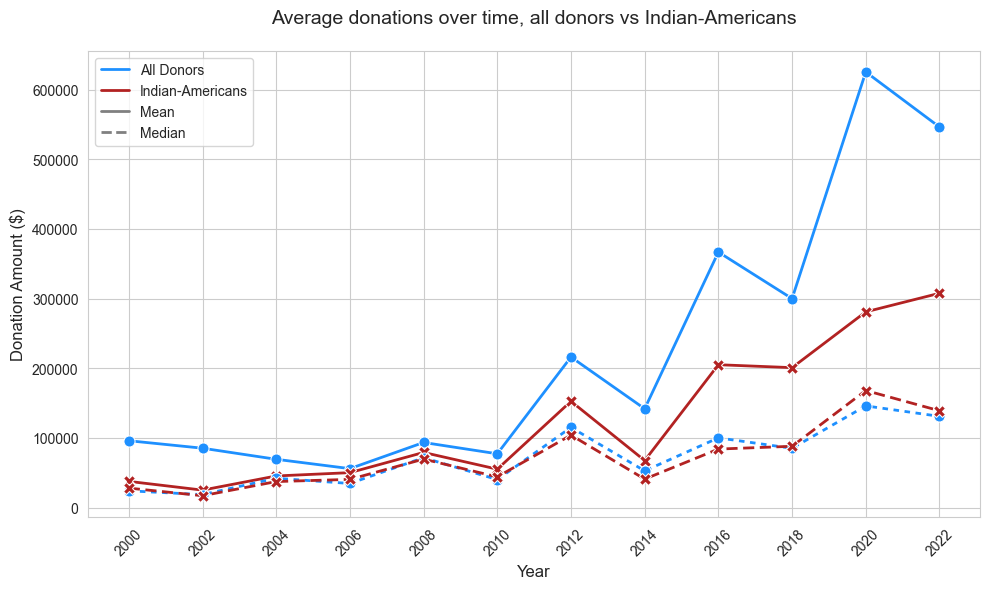

In [14]:
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")

sns.lineplot(
    data=combined, x='cycle', y='mean', hue='group',
    style='group', markers=True, dashes=False,
    palette=['dodgerblue', 'firebrick'],
    linewidth=2, marker='o', markersize=8
)
sns.lineplot(
    data=combined, x='cycle', y='median', hue='group',
    style='group', markers=True, dashes=[(2,2), (4,2)],
    palette=['dodgerblue', 'firebrick'],
    linewidth=2, marker='s', markersize=8,
    legend=False
)

plt.title('Average donations over time, all donors vs Indian-Americans', fontsize=14, pad=20)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Donation Amount ($)', fontsize=12)
plt.xticks(rotation=45)

legend_elements = [
    Line2D([0], [0], color='dodgerblue', lw=2, label='All Donors'),
    Line2D([0], [0], color='firebrick', lw=2, label='Indian-Americans'),
    Line2D([0], [0], color='gray', lw=2, linestyle='-', label='Mean'),
    Line2D([0], [0], color='gray', lw=2, linestyle='--', label='Median')
]
plt.legend(handles=legend_elements, loc='upper left', frameon=True)

plt.tight_layout()
plt.show()

In [15]:
sector_counts_all = (
    all_donors[~all_donors["sector"].isin(["Unknown", "Party", "Ideology/Single Issue"])]
    .groupby(['cycle', 'sector'])
    .size()
    .unstack(fill_value=0)
)

sector_counts_indian = (
    all_donors[~all_donors["sector"].isin(["Unknown", "Party", "Ideology/Single Issue"])][all_donors["ethnic"] == "ind"]
    .groupby(['cycle', 'sector'])
    .size()
    .unstack(fill_value=0)
)

sector_pct_all = sector_counts_all.div(sector_counts_all.sum(axis=1), axis=0) * 100
sector_pct_indian = sector_counts_indian.div(sector_counts_indian.sum(axis=1), axis=0) * 100

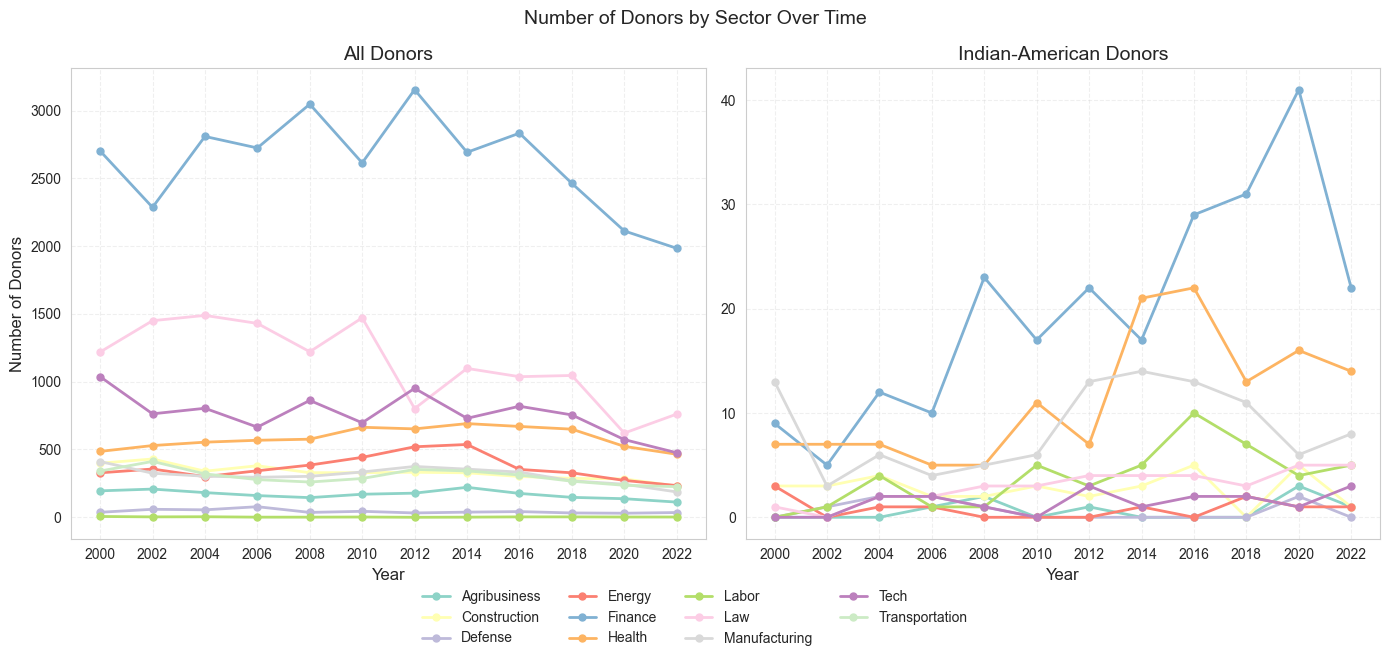

In [16]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), sharey=False)
colors = sns.color_palette("Set3", n_colors=len(sector_counts_all.columns))

for i, sector in enumerate(sector_counts_all.columns):
    ax1.plot(
        sector_counts_all.index,
        sector_counts_all[sector],
        label=sector,
        color=colors[i],
        marker='o',
        markersize=5,
        linewidth=2
    )

ax1.set_title("All Donors", fontsize=14)
ax1.set_xlabel("Year", fontsize=12)
ax1.set_ylabel("Number of Donors", fontsize=12)
ax1.grid(True, linestyle='--', alpha=0.3)

for i, sector in enumerate(sector_counts_indian.columns):
    ax2.plot(
        sector_counts_indian.index,
        sector_counts_indian[sector],
        label=sector,
        color=colors[i],
        marker='o',
        markersize=5,
        linewidth=2
    )

ax2.set_title("Indian-American Donors", fontsize=14)
ax2.set_xlabel("Year", fontsize=12)
ax1.set_ylabel("Number of Donors", fontsize=12)
ax2.grid(True, linestyle='--', alpha=0.3)

handles, labels = ax1.get_legend_handles_labels()
fig.legend(
    handles, labels,
    loc='lower center',
    bbox_to_anchor=(0.5, -0.1),
    ncol=4,
    fontsize=10,
    frameon=False
)

plt.suptitle("Number of Donors by Sector Over Time", fontsize=14)
plt.tight_layout()
plt.show()

In [17]:
sector_counts_all

sector,Agribusiness,Construction,Defense,Energy,Finance,Health,Labor,Law,Manufacturing,Tech,Transportation
cycle,,,,,,,,,,,
2000,195,399,37,328,2702,486,6,1219,411,1037,341
2002,208,430,59,356,2286,529,3,1450,325,763,412
2004,182,340,55,300,2809,554,4,1489,303,804,320
2006,160,380,78,343,2724,568,1,1430,295,665,278
2008,145,329,36,385,3047,576,1,1221,302,862,260
2010,170,329,44,442,2614,664,2,1471,334,697,286
2012,178,332,32,520,3154,652,0,802,375,951,353
2014,221,328,38,537,2692,691,1,1098,355,730,342
2016,176,301,42,353,2833,670,3,1037,333,819,312


In [18]:
sector_counts_indian

sector,Agribusiness,Construction,Defense,Energy,Finance,Health,Law,Manufacturing,Tech,Transportation
cycle,,,,,,,,,,
2000,0,3,0,3,9,7,0,1,13,0
2002,0,3,1,0,5,7,1,0,3,0
2004,0,4,2,1,12,7,4,2,6,2
2006,1,2,2,1,10,5,1,2,4,2
2008,2,2,1,0,23,5,1,3,5,1
2010,0,3,0,0,17,11,5,3,6,0
2012,1,2,0,0,22,7,3,4,13,3
2014,0,3,0,1,17,21,5,4,14,1
2016,0,5,0,0,29,22,10,4,13,2


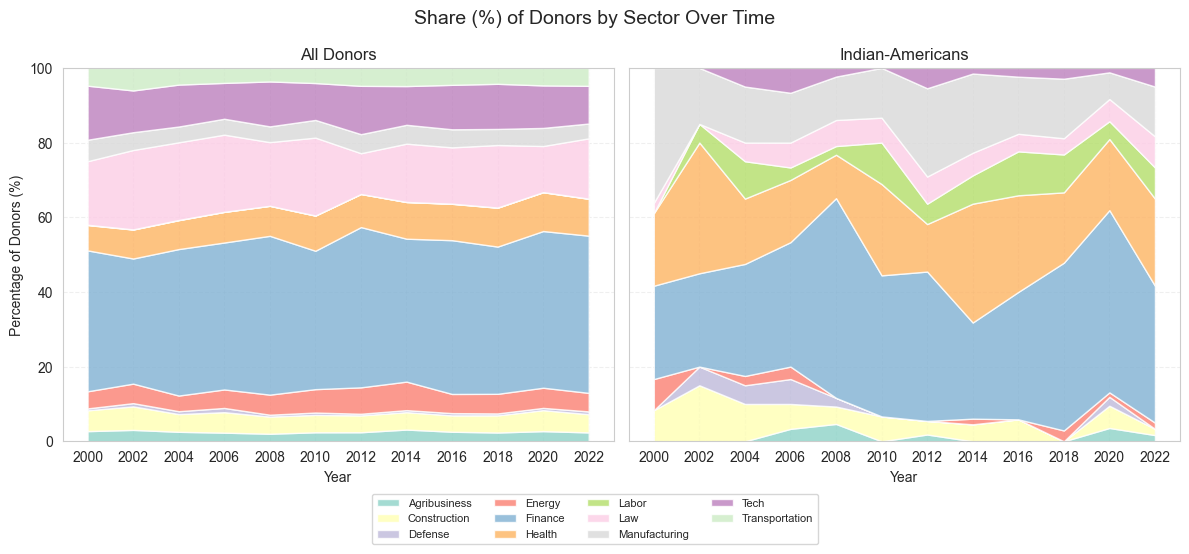

In [19]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
colors = sns.color_palette("Set3", n_colors=len(sector_pct_all.columns))

ax1.stackplot(
    sector_pct_all.index,
    sector_pct_all.T,
    labels=sector_pct_all.columns,
    colors=colors,
    alpha=0.8,
)
ax1.set_title("All Donors", fontsize=12)
ax1.set_xlabel("Year")
ax1.set_ylabel("Percentage of Donors (%)")
ax1.set_ylim(0, 100)
ax1.grid(True, linestyle='--', alpha=0.3)

ax2.stackplot(
    sector_pct_indian.index,
    sector_pct_indian.T,
    labels=sector_pct_indian.columns,
    colors=colors,
    alpha=0.8,
)
ax2.set_title("Indian-Americans", fontsize=12)
ax2.set_xlabel("Year")
ax2.grid(True, linestyle='--', alpha=0.3)

handles, labels = ax1.get_legend_handles_labels()
fig.legend(
    handles, labels,
    loc='lower center',
    bbox_to_anchor=(0.5, -0.1),
    ncol=4,
    fontsize=8
)

plt.suptitle("Share (%) of Donors by Sector Over Time", fontsize=14)
plt.tight_layout()
plt.show()

In [20]:
sector_pct_all

sector,Agribusiness,Construction,Defense,Energy,Finance,Health,Labor,Law,Manufacturing,Tech,Transportation
cycle,,,,,,,,,,,
2000,2.723083,5.571848,0.516688,4.580366,37.732160,6.786762,0.083787,17.022762,5.739422,14.481218,4.761905
2002,3.049406,6.304061,0.864976,5.219176,33.514147,7.755461,0.043982,21.257880,4.764697,11.186043,6.040170
2004,2.541899,4.748603,0.768156,4.189944,39.231844,7.737430,0.055866,20.796089,4.231844,11.229050,4.469274
2006,2.311471,5.489743,1.126842,4.955215,39.352788,8.205721,0.014447,20.658769,4.261774,9.607050,4.016180
2008,2.024009,4.592406,0.502513,5.374093,42.532105,8.040201,0.013959,17.043551,4.215522,12.032384,3.629257
2010,2.410322,4.664682,0.623848,6.266837,37.062243,9.414434,0.028357,20.856373,4.735574,9.882320,4.055012
2012,2.422098,4.517621,0.435433,7.075793,42.917404,8.871955,0.000000,10.913049,5.102735,12.940536,4.803375
2014,3.142329,4.663728,0.540310,7.635433,38.276696,9.825110,0.014219,15.612114,5.047633,10.379639,4.862790
2016,2.558511,4.375636,0.610554,5.131560,41.183312,9.739788,0.043611,15.074866,4.840820,11.905800,4.535543


In [21]:
sector_pct_indian

sector,Agribusiness,Construction,Defense,Energy,Finance,Health,Law,Manufacturing,Tech,Transportation
cycle,,,,,,,,,,
2000,0.000000,8.333333,0.000000,8.333333,25.000000,19.444444,0.000000,2.777778,36.111111,0.000000
2002,0.000000,15.000000,5.000000,0.000000,25.000000,35.000000,5.000000,0.000000,15.000000,0.000000
2004,0.000000,10.000000,5.000000,2.500000,30.000000,17.500000,10.000000,5.000000,15.000000,5.000000
2006,3.333333,6.666667,6.666667,3.333333,33.333333,16.666667,3.333333,6.666667,13.333333,6.666667
2008,4.651163,4.651163,2.325581,0.000000,53.488372,11.627907,2.325581,6.976744,11.627907,2.325581
2010,0.000000,6.666667,0.000000,0.000000,37.777778,24.444444,11.111111,6.666667,13.333333,0.000000
2012,1.818182,3.636364,0.000000,0.000000,40.000000,12.727273,5.454545,7.272727,23.636364,5.454545
2014,0.000000,4.545455,0.000000,1.515152,25.757576,31.818182,7.575758,6.060606,21.212121,1.515152
2016,0.000000,5.882353,0.000000,0.000000,34.117647,25.882353,11.764706,4.705882,15.294118,2.352941


In [22]:
mean_all = all_donors.drop_duplicates(subset=["cycle", "contrib_id", "d_ratio"]).groupby(["cycle", "sector"])["d_ratio"].mean().sort_values(ascending=False)
mean_ind = all_donors.drop_duplicates(subset=["cycle", "contrib_id", "d_ratio"])[all_donors["ethnic"].str.contains("ind", na=False)].groupby(["cycle", "sector"])["d_ratio"].mean().sort_values(ascending=False)
mean_all = mean_all.unstack(level='sector')
mean_ind = mean_ind.unstack(level='sector')

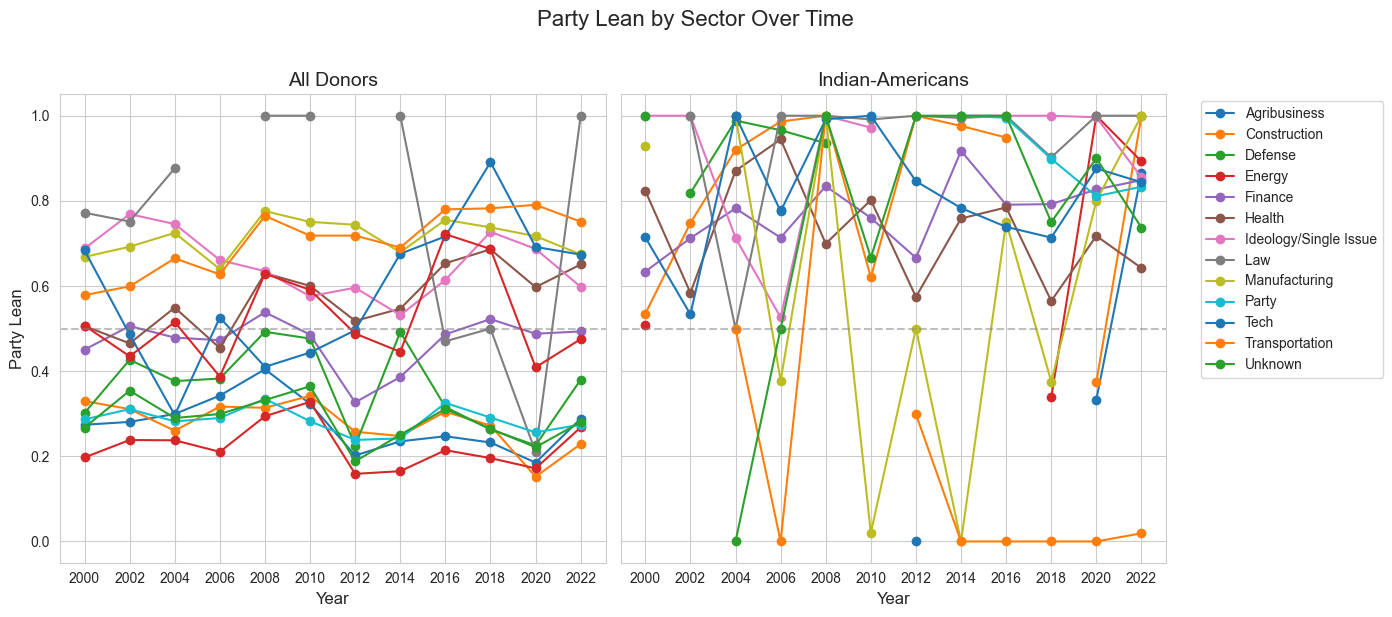

In [23]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

sns.set_style("whitegrid")
sns.set_palette("Set3", n_colors=len(mean_all.columns))

for sector in mean_all.columns:
    ax1.plot(
        mean_all.index,
        mean_all[sector],
        marker='o',
        label=sector
    )
ax1.set_title('All Donors', fontsize=14)
ax1.set_xlabel('Year', fontsize=12)
ax1.set_ylabel('Party Lean', fontsize=12)
ax1.axhline(0.5, color='gray', linestyle='--', alpha=0.5)

for sector in mean_ind.columns:
    ax2.plot(
        mean_ind.index,
        mean_ind[sector],
        marker='o',
        label=sector
    )
ax2.set_title('Indian-Americans', fontsize=14)
ax2.set_xlabel('Year', fontsize=12)
ax2.axhline(0.5, color='gray', linestyle='--', alpha=0.5)

ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.suptitle('Party Lean by Sector Over Time', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

In [24]:
mean_all

sector,Agribusiness,Construction,Defense,Energy,Finance,Health,Ideology/Single Issue,Labor,Law,Manufacturing,Party,Tech,Transportation,Unknown
cycle,,,,,,,,,,,,,,
2000,0.274068,0.329706,0.301895,0.197306,0.450486,0.505941,0.688158,0.772019,0.668313,0.286675,0.683725,0.578584,0.267439,0.507052
2002,0.280771,0.310763,0.426688,0.238216,0.505916,0.465238,0.768836,0.751458,0.692294,0.310693,0.486105,0.599118,0.354048,0.434809
2004,0.299397,0.260085,0.376622,0.237545,0.478777,0.549159,0.745527,0.876527,0.724755,0.282073,0.296815,0.664931,0.289999,0.515183
2006,0.342522,0.316768,0.382573,0.210480,0.472733,0.454188,0.660884,NaN,0.639611,0.289892,0.525918,0.627327,0.299306,0.387225
2008,0.404423,0.313859,0.492431,0.294065,0.538252,0.630188,0.634825,1.000000,0.775910,0.334994,0.410094,0.764595,0.332109,0.628945
2010,0.323409,0.341936,0.476511,0.327887,0.485758,0.600248,0.575808,1.000000,0.750585,0.282326,0.443687,0.718323,0.364444,0.590763
2012,0.201908,0.257685,0.224736,0.158708,0.326611,0.518076,0.596041,NaN,0.743898,0.238443,0.496010,0.718338,0.188269,0.488221
2014,0.235142,0.247603,0.491916,0.165047,0.386208,0.546597,0.531544,1.000000,0.679229,0.241973,0.675644,0.690436,0.250483,0.445447
2016,0.247067,0.304709,0.315747,0.214290,0.486440,0.653434,0.614202,0.470153,0.755551,0.325412,0.716576,0.779962,0.311303,0.721793


In [25]:
mean_ind

sector,Agribusiness,Construction,Defense,Energy,Finance,Health,Ideology/Single Issue,Law,Manufacturing,Party,Tech,Transportation,Unknown
cycle,,,,,,,,,,,,,
2000,NaN,0.534832,NaN,0.508929,0.633838,0.823686,1.000000,NaN,0.928571,NaN,0.714286,NaN,1.000000
2002,NaN,0.747978,0.818182,NaN,0.712500,0.583929,1.000000,1.000000,NaN,NaN,0.533333,NaN,NaN
2004,NaN,0.919712,0.988636,1.000000,0.782265,0.870455,0.712935,0.500000,1.000000,1.000000,1.000000,0.500000,0.000000
2006,0.777778,0.986339,0.965986,NaN,0.713507,0.944622,0.526334,1.000000,0.377778,NaN,0.775584,0.000000,0.500000
2008,NaN,1.000000,0.935484,NaN,0.834452,0.699458,1.000000,1.000000,1.000000,NaN,0.991649,1.000000,1.000000
2010,NaN,0.620690,NaN,NaN,0.760032,0.801764,0.972049,0.991150,0.020253,1.000000,1.000000,NaN,0.666667
2012,0.000000,1.000000,NaN,NaN,0.666215,0.574466,NaN,1.000000,0.500000,NaN,0.846154,0.298701,1.000000
2014,NaN,0.976019,NaN,1.000000,0.917490,0.758596,1.000000,0.994635,0.000000,1.000000,0.783095,0.000000,1.000000
2016,NaN,0.948707,NaN,NaN,0.790956,0.784545,1.000000,1.000000,0.750000,0.995240,0.738943,0.000000,1.000000


In [26]:
dollar_mean_all = (
    all_donors.drop_duplicates(subset=["cycle", "contrib_id", "d_ratio"])
    .groupby(["cycle", "sector"])
    .apply(lambda x: (x["d_ratio"] * x["total_donated"]).sum() / x["total_donated"].sum())
    .unstack(level='sector')
)
dollar_mean_ind = (
    all_donors.drop_duplicates(subset=["cycle", "contrib_id", "d_ratio"])
    [all_donors["ethnic"].str.contains("ind", na=False)]
    .groupby(["cycle", "sector"])
    .apply(lambda x: (x["d_ratio"] * x["total_donated"]).sum() / x["total_donated"].sum())
    .unstack(level='sector')
)

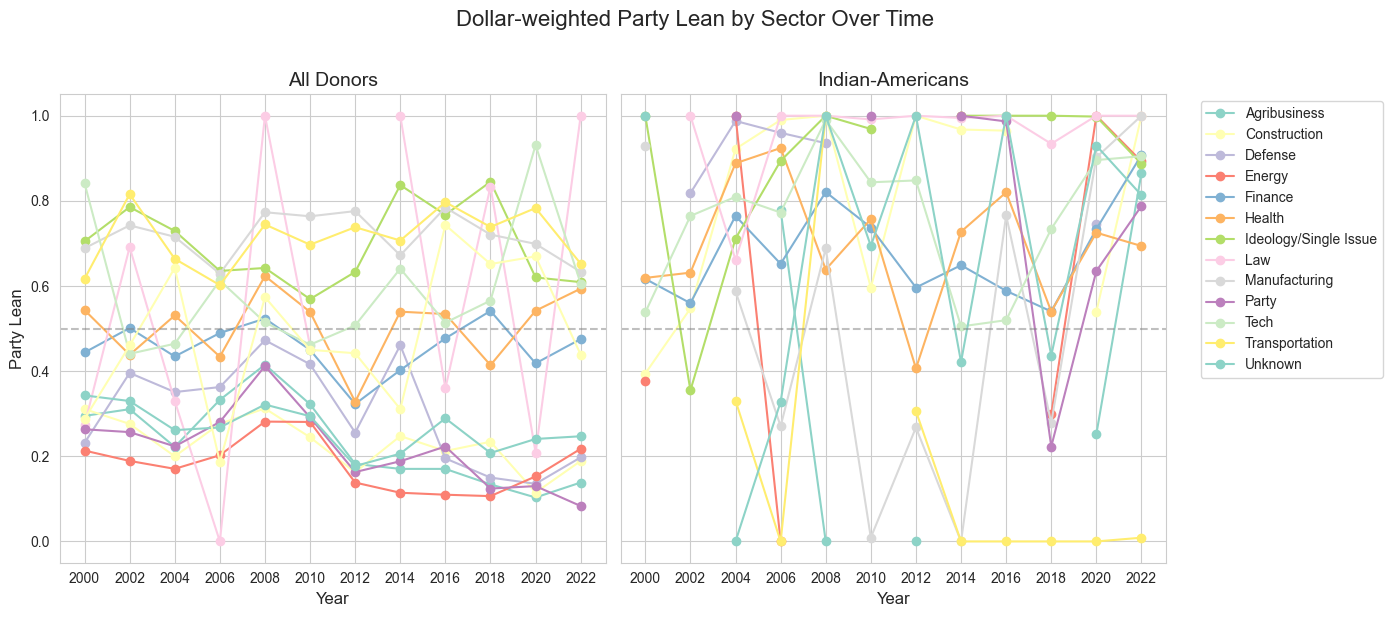

In [27]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

sns.set_style("whitegrid")
sns.set_palette("Set3", n_colors=len(mean_all.columns))

for sector in dollar_mean_all.columns:
    ax1.plot(
        dollar_mean_all.index,
        dollar_mean_all[sector],
        marker='o',
        label=sector
    )
ax1.set_title('All Donors', fontsize=14)
ax1.set_xlabel('Year', fontsize=12)
ax1.set_ylabel('Party Lean', fontsize=12)
ax1.axhline(0.5, color='gray', linestyle='--', alpha=0.5)

for sector in dollar_mean_ind.columns:
    ax2.plot(
        dollar_mean_ind.index,
        dollar_mean_ind[sector],
        marker='o',
        label=sector
    )
ax2.set_title('Indian-Americans', fontsize=14)
ax2.set_xlabel('Year', fontsize=12)
ax2.axhline(0.5, color='gray', linestyle='--', alpha=0.5)

ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.suptitle('Dollar-weighted Party Lean by Sector Over Time', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

In [28]:
dollar_mean_all

sector,Agribusiness,Construction,Defense,Energy,Finance,Health,Ideology/Single Issue,Labor,Law,Manufacturing,Party,Tech,Transportation,Unknown
cycle,,,,,,,,,,,,,,
2000,0.294895,0.310920,0.231503,0.213411,0.443839,0.543416,0.704878,0.273448,0.688673,0.263416,0.841734,0.616802,0.343038,0.287706
2002,0.310656,0.276012,0.395822,0.189128,0.501323,0.438422,0.785401,0.691414,0.742417,0.256794,0.440712,0.815703,0.329778,0.460345
2004,0.222155,0.199957,0.350876,0.170510,0.434534,0.530822,0.729321,0.329830,0.715611,0.223329,0.464357,0.663820,0.261400,0.642529
2006,0.332521,0.276495,0.362616,0.202476,0.489551,0.434060,0.635436,0.000000,0.628921,0.280568,0.612959,0.602052,0.267752,0.186716
2008,0.415198,0.312306,0.472689,0.281486,0.523501,0.623409,0.642376,1.000000,0.773280,0.411877,0.514391,0.744548,0.321550,0.573817
2010,0.322180,0.244607,0.416214,0.280640,0.449909,0.539132,0.569185,0.458669,0.763748,0.291462,0.462113,0.697050,0.294192,0.450108
2012,0.182095,0.162364,0.255774,0.138311,0.322835,0.328099,0.633055,NaN,0.775923,0.162973,0.507419,0.738137,0.177142,0.442050
2014,0.170427,0.247551,0.460855,0.114376,0.402474,0.539689,0.837035,1.000000,0.672161,0.188353,0.640804,0.706834,0.206140,0.310915
2016,0.170380,0.212384,0.195026,0.109756,0.477059,0.534203,0.767309,0.359350,0.784333,0.223000,0.513825,0.796884,0.289148,0.743164


In [29]:
dollar_mean_ind

sector,Agribusiness,Construction,Defense,Energy,Finance,Health,Ideology/Single Issue,Law,Manufacturing,Party,Tech,Transportation,Unknown
cycle,,,,,,,,,,,,,
2000,NaN,0.394423,NaN,0.376438,0.616702,0.619019,1.000000,NaN,0.928571,NaN,0.538089,NaN,1.000000
2002,NaN,0.547239,0.818182,NaN,0.559602,0.631388,0.354839,1.000000,NaN,NaN,0.764557,NaN,NaN
2004,NaN,0.921994,0.987705,1.000000,0.764555,0.888271,0.711425,0.661697,0.587838,1.000000,0.809395,0.331046,0.000000
2006,0.777778,0.989941,0.959806,0.000000,0.652054,0.924074,0.893945,1.000000,0.270585,NaN,0.772515,0.000000,0.327879
2008,0.000000,1.000000,0.935484,NaN,0.820696,0.638736,1.000000,1.000000,0.688159,NaN,0.990171,1.000000,1.000000
2010,NaN,0.595805,NaN,NaN,0.737358,0.757215,0.968813,0.991287,0.009121,1.000000,0.843564,NaN,0.694059
2012,0.000000,1.000000,NaN,NaN,0.596452,0.406314,NaN,1.000000,0.267664,NaN,0.847990,0.306194,1.000000
2014,NaN,0.967554,NaN,1.000000,0.648842,0.727575,1.000000,0.994741,0.000000,1.000000,0.504985,0.000000,0.421532
2016,NaN,0.964911,NaN,NaN,0.588617,0.819993,1.000000,1.000000,0.765938,0.986556,0.519734,0.000000,1.000000


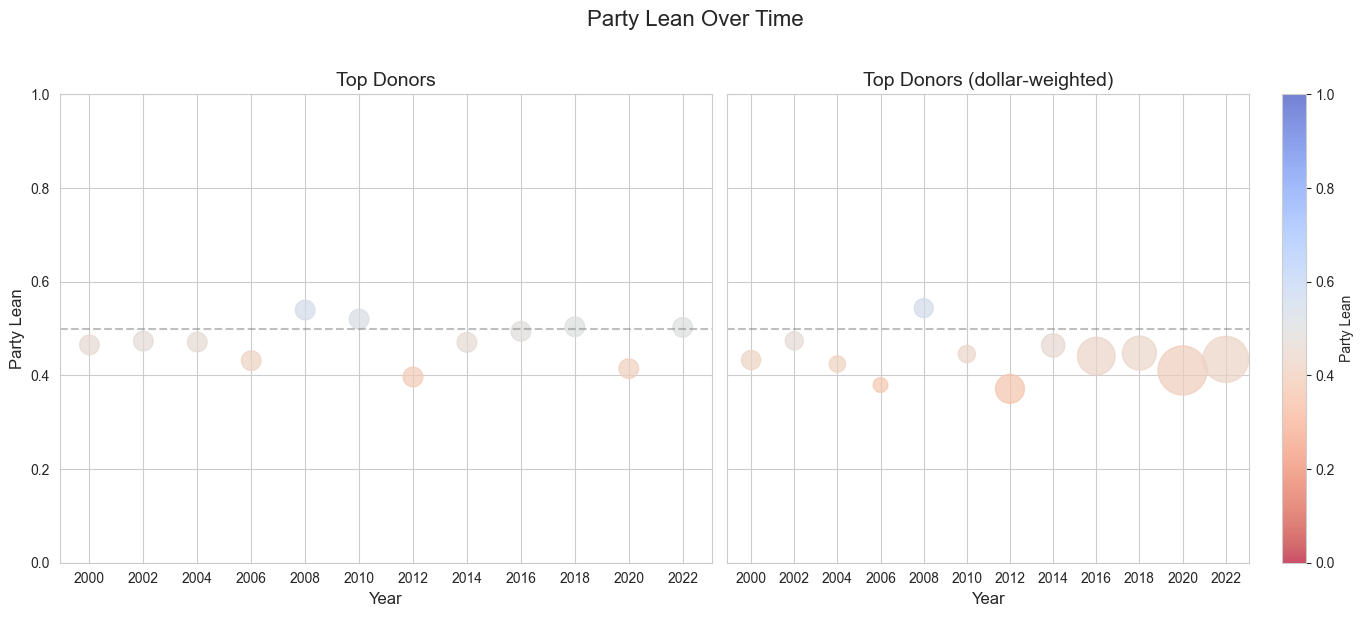

In [30]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

sns.set_style("whitegrid")
sns.set_palette("Set3", n_colors=len(mean_all.columns))

norm1 = plt.Normalize(0, 1)
norm2 = plt.Normalize(0, 1)

sc1 = ax1.scatter(
    mean_all.index,
    mean_all.mean(axis=1),
    s=all_donors.drop_duplicates(subset=["cycle", "contrib_id", "d_ratio"]).groupby(["cycle"])["contrib_id"].count()/50,
    c=mean_all.mean(axis=1),
    cmap=plt.cm.coolwarm_r,
    norm=norm1,
    alpha=0.7,
    label='Mean Party Lean'
)
ax1.set_title('Top Donors', fontsize=14)
ax1.set_xlabel('Year', fontsize=12)
ax1.set_ylabel('Party Lean', fontsize=12)
ax1.set_ylim(0, 1)
ax1.axhline(0.5, color='gray', linestyle='--', alpha=0.5)

sc2 = ax2.scatter(
    dollar_mean_all.index,
    dollar_mean_all.mean(axis=1),
    s=all_donors.drop_duplicates(subset=["cycle", "contrib_id", "d_ratio"]).groupby(["cycle"])["total_donated"].sum()/5000000,
    c=dollar_mean_all.mean(axis=1),
    cmap=plt.cm.coolwarm_r,
    norm=norm1,
    alpha=0.7,
    label='Mean Party Lean'
)
ax2.set_title('Top Donors (dollar-weighted)', fontsize=14)
ax2.set_xlabel('Year', fontsize=12)
ax2.set_ylim(0, 1)
ax2.axhline(0.5, color='gray', linestyle='--', alpha=0.5)

# Add legend and layout adjustments
cbar2 = fig.colorbar(sc2, ax=ax2, orientation='vertical', label='Party Lean')

plt.suptitle('Party Lean Over Time', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

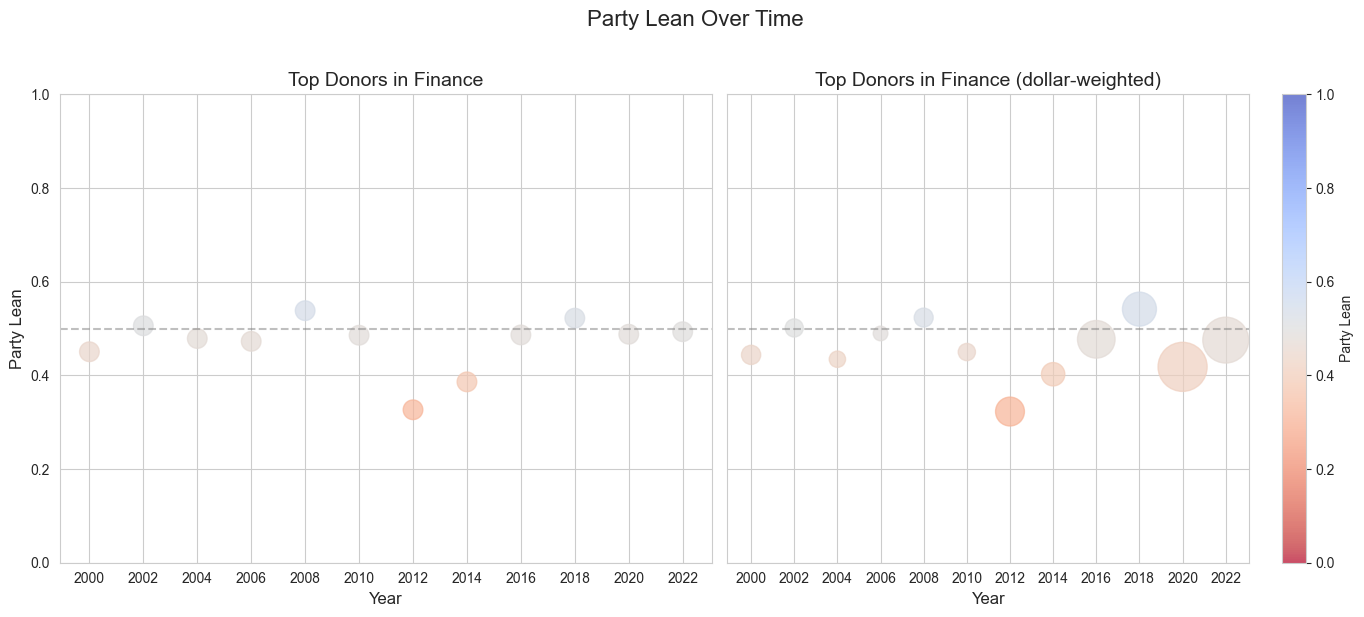

In [31]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

sns.set_style("whitegrid")
sns.set_palette("Set3", n_colors=len(mean_all.columns))

norm1 = plt.Normalize(0, 1)
norm2 = plt.Normalize(0, 1)

sc1 = ax1.scatter(
    mean_all.index,
    mean_all["Finance"],
    s=all_donors.drop_duplicates(subset=["cycle", "contrib_id", "d_ratio"]).groupby(["cycle"])["contrib_id"].count()/50,
    c=mean_all["Finance"],
    cmap=plt.cm.coolwarm_r,
    norm=norm1,
    alpha=0.7,
    label='Mean Party Lean'
)
ax1.set_title('Top Donors in Finance', fontsize=14)
ax1.set_xlabel('Year', fontsize=12)
ax1.set_ylabel('Party Lean', fontsize=12)
ax1.set_ylim(0, 1)
ax1.axhline(0.5, color='gray', linestyle='--', alpha=0.5)

sc2 = ax2.scatter(
    dollar_mean_all.index,
    dollar_mean_all["Finance"],
    s=all_donors.drop_duplicates(subset=["cycle", "contrib_id", "d_ratio"]).groupby(["cycle"])["total_donated"].sum()/5000000,
    c=dollar_mean_all["Finance"],
    cmap=plt.cm.coolwarm_r,
    norm=norm1,
    alpha=0.7,
    label='Mean Party Lean'
)
ax2.set_title('Top Donors in Finance (dollar-weighted)', fontsize=14)
ax2.set_xlabel('Year', fontsize=12)
ax2.set_ylim(0, 1)
ax2.axhline(0.5, color='gray', linestyle='--', alpha=0.5)

# Add legend and layout adjustments
cbar2 = fig.colorbar(sc2, ax=ax2, orientation='vertical', label='Party Lean')

plt.suptitle('Party Lean Over Time', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

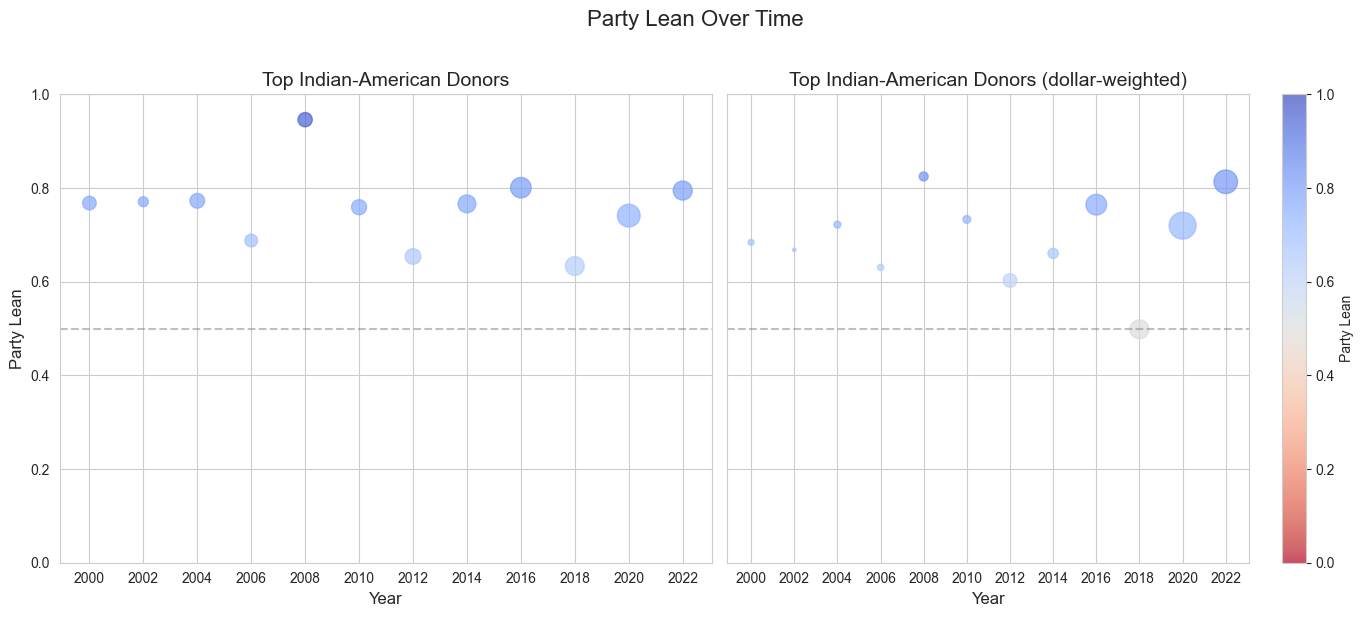

In [32]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

sns.set_style("whitegrid")
sns.set_palette("Set3", n_colors=len(mean_all.columns))

norm1 = plt.Normalize(0, 1)
norm2 = plt.Normalize(0, 1)

sc1 = ax1.scatter(
    mean_ind.index,
    mean_ind.mean(axis=1),
    s=all_donors[all_donors["ethnic"] == "ind"].drop_duplicates(subset=["cycle", "contrib_id", "d_ratio"]).groupby(["cycle"])["contrib_id"].count()*2,
    c=mean_ind.mean(axis=1),
    cmap=plt.cm.coolwarm_r,
    norm=norm1,
    alpha=0.7,
    label='Mean Party Lean'
)
ax1.set_title('Top Indian-American Donors', fontsize=14)
ax1.set_xlabel('Year', fontsize=12)
ax1.set_ylabel('Party Lean', fontsize=12)
ax1.set_ylim(0, 1)
ax1.axhline(0.5, color='gray', linestyle='--', alpha=0.5)

sc2 = ax2.scatter(
    dollar_mean_ind.index,
    dollar_mean_ind.mean(axis=1),
    s=all_donors[all_donors["ethnic"] == "ind"].drop_duplicates(subset=["cycle", "contrib_id", "d_ratio"]).groupby(["cycle"])["total_donated"].sum()/100000,
    c=dollar_mean_ind.mean(axis=1),
    cmap=plt.cm.coolwarm_r,
    norm=norm1,
    alpha=0.7,
    label='Mean Party Lean'
)
ax2.set_title('Top Indian-American Donors (dollar-weighted)', fontsize=14)
ax2.set_xlabel('Year', fontsize=12)
ax2.set_ylim(0, 1)
ax2.axhline(0.5, color='gray', linestyle='--', alpha=0.5)

# Add legend and layout adjustments
cbar2 = fig.colorbar(sc2, ax=ax2, orientation='vertical', label='Party Lean')

plt.suptitle('Party Lean Over Time', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

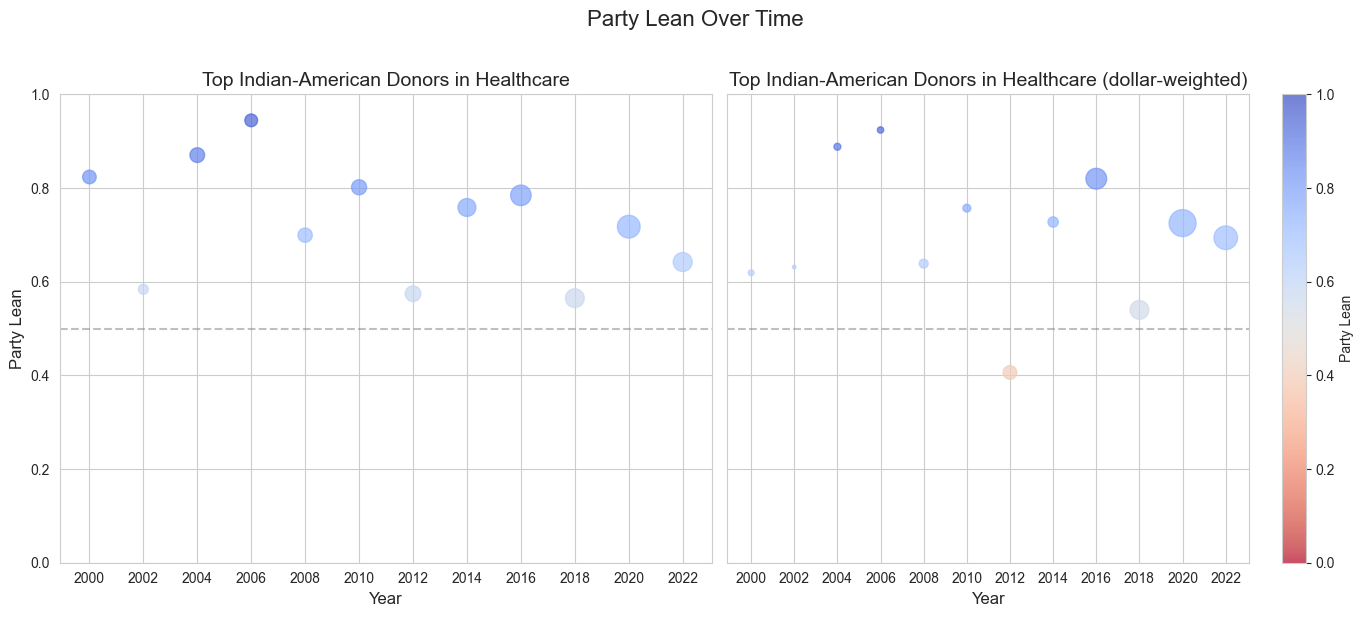

In [33]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

sns.set_style("whitegrid")
sns.set_palette("Set3", n_colors=len(mean_all.columns))

norm1 = plt.Normalize(0, 1)
norm2 = plt.Normalize(0, 1)

sc1 = ax1.scatter(
    mean_ind.index,
    mean_ind["Health"],
    s=all_donors[all_donors["ethnic"] == "ind"].drop_duplicates(subset=["cycle", "contrib_id", "d_ratio"]).groupby(["cycle"])["contrib_id"].count()*2,
    c=mean_ind["Health"],
    cmap=plt.cm.coolwarm_r,
    norm=norm1,
    alpha=0.7,
    label='Mean Party Lean'
)
ax1.set_title('Top Indian-American Donors in Healthcare', fontsize=14)
ax1.set_xlabel('Year', fontsize=12)
ax1.set_ylabel('Party Lean', fontsize=12)
ax1.set_ylim(0, 1)
ax1.axhline(0.5, color='gray', linestyle='--', alpha=0.5)

sc2 = ax2.scatter(
    dollar_mean_ind.index,
    dollar_mean_ind["Health"],
    s=all_donors[all_donors["ethnic"] == "ind"].drop_duplicates(subset=["cycle", "contrib_id", "d_ratio"]).groupby(["cycle"])["total_donated"].sum()/100000,
    c=dollar_mean_ind["Health"],
    cmap=plt.cm.coolwarm_r,
    norm=norm1,
    alpha=0.7,
    label='Mean Party Lean'
)
ax2.set_title('Top Indian-American Donors in Healthcare (dollar-weighted)', fontsize=14)
ax2.set_xlabel('Year', fontsize=12)
ax2.set_ylim(0, 1)
ax2.axhline(0.5, color='gray', linestyle='--', alpha=0.5)

# Add legend and layout adjustments
cbar2 = fig.colorbar(sc2, ax=ax2, orientation='vertical', label='Party Lean')

plt.suptitle('Party Lean Over Time', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

In [34]:
all_donors[(all_donors["ethnic"] == "ind") & (all_donors["sector"] == "Health")].groupby(["cycle", "tag"])["total_donated"].sum()

cycle  tag               
2000   Leans Democrat          71050.0
       Leans Republican        23800.0
       Only Democrat          108750.0
       Unknown                 70769.0
2002   Leans Democrat          17500.0
       Leans Republican        44250.0
       Only Democrat           12500.0
       Only Republican         17000.0
       Solidly Democrat        80200.0
2004   Leans Democrat          59750.0
       Only Democrat          110500.0
       Solidly Democrat       108400.0
2006   Only Democrat          100500.0
       Solidly Democrat       108650.0
2008   Leans Democrat          79000.0
       Only Democrat          186500.0
       Only Republican        132425.0
       Solidly Democrat        78324.0
2010   Leans Democrat          45700.0
       Leans Republican        93700.0
       Only Democrat          244146.0
       Solidly Democrat       105900.0
       Solidly Republican      23450.0
       Unknown                 30400.0
2012   Leans Democrat         200797.0

In [35]:
all_donors[(all_donors["ethnic"] == "ind") & (all_donors["cycle"] == "2016")].sort_values(by="total_donated", ascending=False)[["cycle", "name_new", "orgname", "sector", "state", "ethnic", "tag"]]

,cycle,name_new,orgname,sector,state,ethnic,tag
90164,2016,Muneer A Satter,Satter Investment Management,Finance,IL,ind,Only Republican
90194,2016,Amy Joyce Rao,Integrated Archive Systems,Tech,CA,ind,Only Democrat
90259,2016,Rishi U Shah,Contextmedia,Health,IL,ind,Only Democrat
90293,2016,Shashikant Gupta,Apex Covantage,NaN,VA,ind,Only Democrat
90315,2016,Vivek Garipalli,Bayonne Medical Center,Health,NJ,ind,Only Democrat
...,...,...,...,...,...,...,...
99567,2016,Sonia Kapadia,Soroban Capital Partners,Finance,NY,ind,Only Democrat
99616,2016,Vinit Bodas,Deccan Value Investors,Finance,CT,ind,Only Democrat
99641,2016,Shaalu Mehra,"Gibson, Dunn & Crutcher",Law,CA,ind,Only Democrat
99777,2016,Kiran Mehta,K&L Gates,Law,NC,ind,Only Democrat


In [36]:
top_donors_per_year = (
    all_donors[all_donors["ethnic"] == "ind"].sort_values(by=["cycle", "total_donated"], ascending=[True, False])
    .groupby("cycle")
    .head(20)
)
top_donors_per_year["name_new"].value_counts()[top_donors_per_year["name_new"].value_counts() > 4]

name_new
Shekar Narasimhan    10
Vinod Khosla          8
Amy Rao               6
Prem Reddy            6
Vinod Gupta           5
Sunil Puri            5
Parag Saxena          5
Dinakar Singh         5
Niranjan S Shah       5
Name: count, dtype: int64

In [37]:
high_value_donors = all_donors[(all_donors["ethnic"] == "ind") & (all_donors["total_donated"] > 100000)]
high_value_donors["name_new"].value_counts()[high_value_donors["name_new"].value_counts() > 4]

name_new
Shekar Narasimhan    8
Vinod Khosla         6
Sunil Puri           6
Parag Saxena         6
Deven Parekh         6
Shashikant Gupta     6
Muneer A Satter      5
Name: count, dtype: int64

In [38]:
mega_donors = all_donors[(all_donors["ethnic"] == "ind")].groupby(["contrib_id", "name_new"])["total_donated"].sum().reset_index()
mega_donors[mega_donors["total_donated"] > 1000000].sort_values(by="total_donated", ascending=False)

,contrib_id,name_new,total_donated
32,U0000004761,Nishad Singh,9476000.0
9,U00000033011,Vinod Khosla,6361995.0
292,h3003465387,Shiva Dr Ayyadurai,4817653.0
11,U00000035581,Muneer A Satter,3928500.0
226,h10013502001,Prem Reddy,3122199.0
427,m0001327150,Sameer Gandhi,2357999.0
31,U0000004554,Vivek Garipalli,1905600.0
265,h30013924601,Shashikant Gupta,1895747.0
251,h3001220400,Nirmal Mulye,1732299.0
6,U00000003781,Amy Rao,1712133.0


In [39]:
all_donors[all_donors["name_new"] == "Vinod Khosla"].sort_values(by="total_donated", ascending=False)[["cycle", "name_new", "state", "total_donated"]]

,cycle,name_new,state,total_donated
149,2020,Vinod Khosla,CA,2410795.0
110197,2022,Vinod Khosla,CA,2084900.0
70097,2012,Vinod Khosla,CA,1160300.0
80679,2014,Vinod Khosla,CA,217900.0
51511,2008,Vinod Khosla,CA,122300.0
60683,2010,Vinod Khosla,CA,121900.0
7787,2020,Vinod Khosla,,100000.0
41121,2006,Vinod Khosla,CA,85100.0
97143,2016,Vinod Khosla,CA,70800.0
32625,2004,Vinod Khosla,CA,62000.0


In [40]:
lf = (
        pl.scan_csv(
            f"./data/CampaignFin{year}/cmtes{year}.txt",
            separator=',', 
            quote_char='|', 
            encoding='utf8-lossy', 
            has_header=False,
            new_columns=['dummy1', 'cmte_id', 'pac_short', 'affiliate', 'pac', 
                        'recip_id', 'recipcode', 'cand_id', 'party', 'prim_code', 
                        'source', 'sensitive', 'foreign', 'active'],
        )
        .select(['cmte_id', 'pac_short', 'affiliate', 'pac',
                 'recip_id', 'recipcode', 'cand_id', 'party', 'prim_code',
                 'source', 'sensitive', 'foreign', 'active'])
    )
cmtes = lf.collect(streaming=True)
cmtes.head(10)

cmte_id,pac_short,affiliate,pac,recip_id,recipcode,cand_id,party,prim_code,source,sensitive,foreign,active
str,str,str,str,str,str,str,str,str,str,str,i64,i64
"""C00000059""","""Hallmark Cards""",null,"""Hallmark Cards""","""C00000059""","""PB""",null,null,"""C1400""","""WAA21""","""Y""",0,1
"""C00000422""","""American Medical Assn""","""American Medical Assn""","""American Medical Assn""","""C00000422""","""PB""",null,null,"""H1100""","""WAA21""","""n""",0,1
"""C00000489""","""Teamsters Local 886""","""Teamsters Union""","""Teamsters Union""","""C00000489""","""PL""",null,""" ""","""LT300""","""WAA21""","""n""",0,1
"""C00000547""","""KANSAS MEDICAL SOCIETY POLITIC…",null,null,"""C00000547""",null,null,"""U""",null,null,null,0,0
"""C00000729""","""American Dental Assn""","""American Dental Assn""","""American Dental Assn""","""C00000729""","""PB""",null,null,"""H1400""","""WAA21""","""n""",0,1
"""C00000885""","""Painters & Allied Trades Union""","""Painters & Allied Trades Union""","""Painters & Allied Trades Union""","""C00000885""","""PL""",null,null,"""LB100""","""WAA21""","""N""",0,1
"""C00000901""","""National Assn of Home Builders""","""National Assn of Home Builders""","""National Assn of Home Builders""","""C00000901""","""PB""",null,null,"""B2000""","""WAA21""","""n""",0,1
"""C00000935""","""Democratic Congressional Campa…","""Democratic Congressional Campa…","""Democratic Congressional Campa…","""C00000935""","""DP""",null,"""D""","""Z5200""","""Rept""","""n""",0,1
"""C00000984""","""US Telecom Assn""",null,"""US Telecom Assn""","""C00000984""","""PB""",null,null,"""C4100""","""WAA21""","""n""",0,1


In [41]:
cmtes["pac_short"].value_counts()

pac_short,count
str,u32
"""Grant Smith Ellis for Congress""",1
"""Sky Is Blue PAC""",1
"""Patel for Pennsylvania""",1
"""Operating Engineers Local 825""",1
"""Save America Fund (Florida)""",1
…,…
"""7th District Congressional Rep…",1
"""RED MASSACHUSETTS GRASSROOTS A…",1
"""Brave PAC""",1


In [42]:
lf = (
        pl.scan_csv(
            f"./data/CampaignFin{year}/pacs{year}.txt",
            separator=',', 
            quote_char='|', 
            encoding='utf8-lossy', 
            has_header=False,
            new_columns=['dummy1', 'rec_no', 'pac_id', 'cand_id', 'amount', 
                        'dummy2', 'realcode', 'type', 'direct', 'cand_id'],
        )
        .select(['rec_no', 'pac_id', 'cand_id', 'amount', 
                 'realcode', 'type', 'direct', 'cand_id'])
    )
pacs = lf.collect(streaming=True)
pacs.head(10)

rec_no,pac_id,cand_id,amount,realcode,type,direct,cand_id
i64,str,str,i64,str,str,str,str
1011020220264924462,"""C00406124""","""N00029513""",500,"""B4000""","""24K""","""D""","""N00029513"""
1011320230265253020,"""C00032979""","""N00041569""",-2500,"""Z9600""","""24K""","""D""","""N00041569"""
1011320230265254779,"""C00032979""","""N00041511""",-5000,"""Z9600""","""24K""","""D""","""N00041511"""
1011320230265254798,"""C00032979""","""N00035575""",5000,"""Z9600""","""24K""","""D""","""N00035575"""
1011320230265254809,"""C00032979""","""N00041511""",4000,"""Z9600""","""24K""","""D""","""N00041511"""
1011320230265254815,"""C00032979""","""N00033030""",2000,"""Z9600""","""24K""","""D""","""N00033030"""
1011320230265254816,"""C00032979""","""N00038601""",1000,"""Z9600""","""24K""","""D""","""N00038601"""
1011320230265254817,"""C00032979""","""N00049050""",2500,"""Z9600""","""24K""","""D""","""N00049050"""
1011320230265254819,"""C00032979""","""N00007360""",2500,"""Z9600""","""24K""","""D""","""N00007360"""


In [43]:
pacs["cand_id"].value_counts()

cand_id,count
str,u32
"""N00044461""",300
"""N00026631""",219
"""N00030026""",2245
"""N00048832""",5116
"""N00030910""",642
…,…
"""N00007999""",278
"""N00013323""",737
"""N00048657""",2


In [44]:
lf = (
        pl.scan_csv(
            f"./data/CampaignFin{year}/pac_other{year}.txt",
            separator=',', 
            quote_char='|', 
            encoding='utf8-lossy', 
            has_header=False,
            new_columns=['dummy1', 'rec_no', 'filer_id', 'donor_name', 'other_name', 
                        'city', 'state', 'zip', 'donor_occupation', 'primcode', 
                        'date', 'amount', 'recip_id', 'party', 'other_id', 'recipcode',
                        'recipprimcode', 'amend', 'report', 'pg', 'microfilm', 'type',
                        'realcode', 'source'],
        )
        .select(['rec_no', 'filer_id', 'donor_name', 'other_name', 
                        'city', 'state', 'donor_occupation', 'primcode', 
                        'amount', 'recip_id', 'party', 'other_id', 'recipcode',
                        'recipprimcode', 'pg', 'type', 'realcode'])
    )
pac2pacs = lf.collect(streaming=True)
pac2pacs.head(10)

rec_no,filer_id,donor_name,other_name,city,state,donor_occupation,primcode,amount,recip_id,party,other_id,recipcode,recipprimcode,pg,type,realcode
i64,str,str,str,str,str,str,str,f64,str,str,str,str,str,str,str,str
1011320230265253021,"""C00032979""","""Teamsters Union""","""BOHANNAN VICTORY FUND""","""IOWA CITY""","""IA""",null,"""LT300""",-1000.0,"""C00811059""","""D""","""C00811059""","""DP""","""Z4200""","""P""","""24K""","""LT300"""
1011320230265254787,"""C00032979""","""Teamsters Union""","""WARNOCK VICTORY FUND""","""WASHINGTON""","""DC""",null,"""LT300""",15000.0,"""C00740597""","""D""","""C00740597""","""DP""","""Z4200""","""P""","""24K""","""LT300"""
1011320230265254797,"""C00032979""","""Teamsters Union""","""BLUE POWER PAC""","""COLLINSWOOD""","""NJ""",null,"""LT300""",5000.0,"""C00575894""","""D""","""C00575894""","""PI""","""J2100""","""P""","""24K""","""LT300"""
1011320230265254799,"""C00032979""","""Teamsters Union""","""COMMONWEALTH PAC""","""MERRIFIELD""","""VA""",null,"""LT300""",5000.0,"""C00498931""","""D""","""C00498931""","""PI""","""J2100""","""P""","""24K""","""LT300"""
1011320230265254826,"""C00032979""","""Teamsters Union""","""RHODE ISLAND DEMOCRATIC STATE …","""PROVIDENCE""","""RI""",null,"""LT300""",5000.0,"""C00136200""","""D""","""C00136200""","""DP""","""Z5200""","""P""","""24K""","""LT300"""
1011320230265254975,"""C00032979""","""Teamsters Union""","""SAVE AMERICA FUND""","""PROVIDENCE""","""RI""",null,"""LT300""",50000.0,"""C00732172""",""" ""","""C00732172""","""OI""","""J1200""","""P""","""24K""","""LT300"""
1011320230265254976,"""C00032979""","""Teamsters Union""","""IN UNION USA""","""WASHINGTON""","""DC""",null,"""LT300""",100000.0,"""C00745745""",null,"""C00745745""","""OI""","""J1200""","""P""","""24K""","""LT300"""
1011320230265254980,"""C00032979""","""Teamsters Union""","""HOUSE MAJORITY PAC""","""WASHINGTON""","""DC""",null,"""LT300""",100000.0,"""C00495028""",null,"""C00495028""","""PI""","""J1200""","""P""","""24K""","""LT300"""
1011320230265254984,"""C00032979""","""Teamsters Union""","""SHORE PAC""","""LONG BRANCH""","""NJ""",null,"""LT300""",5000.0,"""C00410308""","""D""","""C00410308""","""PI""","""J2100""","""P""","""24K""","""LT300"""


In [45]:
pac2pacs["recip_id"].value_counts()

recip_id,count
str,u32
"""C00823278""",12
"""N00048764""",3
"""C00150672""",830
"""C00324483""",2
"""C00007922""",109
…,…
"""N00049825""",5
"""C00507699""",1
"""C00027359""",2


In [47]:
donors_csv = f"./data/CampaignFin{year}/donors_recip{year}.csv"
donors = pd.read_csv(donors_csv)
donors

MemoryError: Unable to allocate 456. MiB for an array with shape (10, 5979614) and data type object